# MLP Final Project

The problem of interest is the evaluation of a State program in Brazil to help consumers choose between gasoline and ethanol when purchasig fuel. In Brazil, ethanol is a viable and renewable source of fuel (it comes from sugar cane, and therefore its environmental impact is supposed to be zero). Combined with a technology that allows some vehicles to run either by gasoline or ethanol, brazilian fleet has been gradually replaced by these flex fuel vehicles (FFV) since their introduction back in 2003. In 2007, Espirito Santo was the first State to come upo with a law mandating all gas stations to show the price ratio of both fuels (price ethanol / price gasoline). This measure is important since the effectiveness of ethanol is lower than that of gasoline. If Ethanol prices are above the threshold of 70% of gasoline price, then gasoline will be comparatively cheaper than ethanol. With the ratio in sight, consumers can make conscious decisions based on which fuel is more efficient by the time of purchase.

Following Espirito Santo, other States in Brazil gradually started to apply the same law. Until the end of 2014, the following States presented this same law:

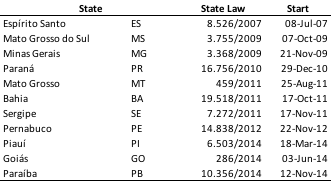

Our task here is to evaluate the impact of this law, by analysing if the share of ethanol in the total fuel purchased has incresed since the introduction of this law in each of these States. To do so, we're going to use a propensity score model, with inverse probability of treatment weighting.

This data was firstly treated in Stata (for a working paper in progress) in previous work trying to apply some structural model treatment to this problem. Therefore, all complex data-analysis was previously done on Stata. Following codes import those data to python and give the proper data-treatment in order to apply the propensity score methodology.

In [2]:
import pandas as pd
import numpy as np
from pandas.core import datetools

/Users/kolmogorov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
from math import exp, log

import scipy as sp
from scipy import stats
from scipy.special import expit

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

%matplotlib inline 

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = 10, 8

np.seterr(divide='ignore', invalid='ignore')
np.random.seed(42)

In [12]:
filename = '/kolmogorov/OneDrive/Nerv/2_PhD/7_MachineLearning/90904_ML_for_Policy_Heinz/Final_Project/Data.dta'
data = pd.read_stata(filename)
pd.set_option('display.max_columns', None)

In [13]:
data.head(7)

,uf,oil,white_sugar,pop,frota_flex,educ1a3,educ4a7,educmais8,homens,S_int_gas,Pr_int_gas,Pr_int_etl,logExpend_nt,ES,MS,MG,PR,MT,BA,SE,PE,Lei,trend_id
0,AC,20.309677,9.0706,69773,0.0,0.40095,0.25641,0.31191,0.502931,0.968269,1.457477,1.161640,6.153464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
1,AC,16.593000,8.8663,69773,0.0,0.40095,0.25641,0.31191,0.502931,0.967253,1.449299,1.157730,5.838490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0
2,AC,16.448387,8.3600,69773,0.0,0.40095,0.25641,0.31191,0.502931,0.976367,1.481630,1.154934,6.129922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,AC,13.090000,8.0252,69773,0.0,0.40095,0.25641,0.31191,0.502931,0.972107,1.478897,1.146668,5.958720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0
4,AC,11.883549,7.6976,69773,0.0,0.40095,0.25641,0.31191,0.502931,0.979288,1.472171,1.127617,5.838696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
5,AC,13.355162,7.9140,71570,0.0,0.39270,0.23732,0.33042,0.502990,0.964626,1.335917,1.127999,6.131779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
6,AC,14.062500,8.5489,71570,0.0,0.39270,0.23732,0.33042,0.502990,0.970281,1.279159,1.127928,6.074398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0


In [14]:
data.describe()

,oil,white_sugar,pop,frota_flex,educ1a3,educ4a7,educmais8,homens,S_int_gas,Pr_int_gas,Pr_int_etl,logExpend_nt,ES,MS,MG,PR,MT,BA,SE,PE,Lei,trend_id
count,60719.000000,60719.000000,6.071900e+04,6.071900e+04,60719.000000,60719.000000,60719.000000,60719.000000,60719.000000,60719.000000,60557.000000,60719.000000,60719.000000,60719.000000,60719.000000,60719.000000,60719.000000,60719.000000,60719.000000,60719.000000,60719.000000,60719.000000
mean,45.189507,14.034511,2.512919e+05,1.018853e+04,0.228443,0.195515,0.508363,0.490334,0.856662,1.251478,0.847252,7.565628,0.031226,0.014658,0.127127,0.054793,0.014625,0.067162,0.008432,0.050610,0.078756,20990.931641
std,18.921318,6.514945,6.653410e+05,4.997164e+04,0.086656,0.068033,0.106636,0.010976,0.113306,0.097725,0.187088,1.170223,0.173931,0.120255,0.333064,0.227505,0.120123,0.250093,0.091427,0.219064,0.269438,16006.717773
min,11.883549,6.170700,1.544500e+04,0.000000e+00,0.076200,0.044900,0.114830,0.242037,0.000000,0.939376,0.014727,0.736228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
25%,29.010645,8.548900,7.564400e+04,1.513333e+02,0.167420,0.140870,0.442100,0.484329,0.804660,1.178885,0.736147,6.819324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7980.500000
50%,45.606773,12.276700,1.104480e+05,1.838000e+03,0.204220,0.191640,0.518360,0.490120,0.892924,1.248272,0.863160,7.470674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17181.000000
75%,59.541935,19.038200,2.193180e+05,7.293207e+03,0.264440,0.245600,0.584260,0.496688,0.937800,1.321782,0.971109,8.234212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31082.000000
max,94.650322,27.606701,1.137668e+07,1.942614e+06,0.615900,0.460920,0.807040,0.543312,1.000000,1.630431,1.543319,12.840391,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72540.000000


Our original model will contemplate the following variables as potential confounders to explain the fuel share. Also, we suppose our treatment (a State applying the mentioned law) can be affected by some fo the other explanatory variables. 

Model: Share Gasoline = $\alpha(Total Expenditure) + \beta(Vehicle Fleet)  + \gamma(Prices) + \delta(Controls)$ 

This model is based on the second stage of an Almost Ideal Demand System (AIDS). Here, we model how the share of a product (in our case, gasoilne) changes after the intriduction of the mentioned law. The price vector contains gasoline and ethanol prices, while the controls used are: population, share of males, seasonal dummies and  city trend, besides a dummy to indicate the treated cities in time.


In [18]:
dataset = data[['S_int_gas', 'logExpend_nt',   'Pr_int_gas', 'Pr_int_etl', 'frota_flex', \
               'pop', 'homens', 'trend_id', 'Lei']]
data_heatmap = data[['S_int_gas', 'logExpend_nt',  'Pr_int_gas', 'Pr_int_etl', 'frota_flex', \
               'pop', 'homens']]

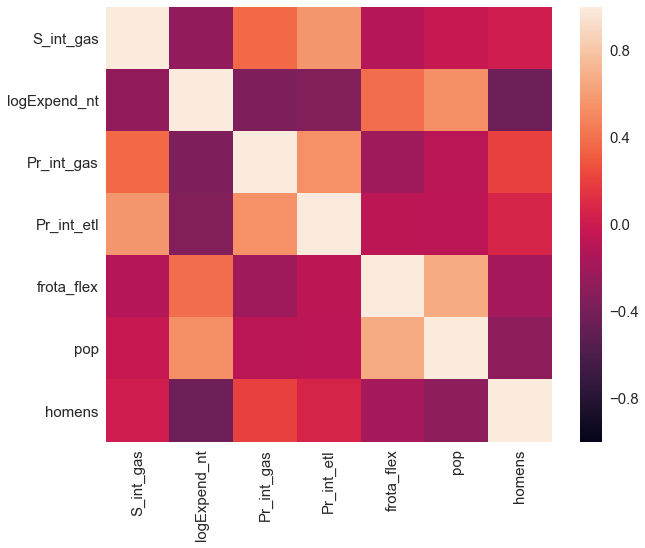

In [19]:
sns.heatmap(data_heatmap.corr(), vmin=-1, vmax=1);

In [22]:
covariates = [ 'logExpend_nt', 'frota_flex', 'Pr_int_gas', 'Pr_int_etl', 'Lei',  'pop', 'homens', \
              'trend_id', 'educ1a3', 'educ4a7', 'educmais8', 'ES', 'MS', 'MG', 'PR', 'MT', 'BA', 'SE', 'PE' ]


In [23]:
data[covariates].isnull().sum().sum()

162

In [24]:
data['Pr_int_etl'].isnull().any()

True

In [25]:
X_clean = data[covariates].dropna()
X_clean.isnull().sum().sum()

0

In [26]:
info = ['S_int_gas', 'logExpend_nt', 'frota_flex', 'Pr_int_gas', 'Pr_int_etl', 'Lei',  'pop', 'homens', \
        'trend_id', 'educ1a3', 'educ4a7', 'educmais8', 'ES', 'MS', 'MG', 'PR', 'MT', 'BA', 'SE', 'PE' ]
database = data[info].dropna()

In [27]:
X = data[covariates]
y = database['S_int_gas']
dataset.head()



,S_int_gas,logExpend_nt,Pr_int_gas,Pr_int_etl,frota_flex,pop,homens,trend_id,Lei
0,0.968269,6.153464,1.457477,1.161640,0.0,69773,0.502931,20.0,0.0
1,0.967253,5.838490,1.449299,1.157730,0.0,69773,0.502931,21.0,0.0
2,0.976367,6.129922,1.481630,1.154934,0.0,69773,0.502931,22.0,0.0
3,0.972107,5.958720,1.478897,1.146668,0.0,69773,0.502931,23.0,0.0
4,0.979288,5.838696,1.472171,1.127617,0.0,69773,0.502931,24.0,0.0


In [28]:
database.isnull().sum().sum()

0

In [29]:
import math
reg = RandomForestRegressor()
X = X_clean.drop(['Lei'], axis=1).as_matrix()
y = X_clean['Lei'].values
reg.fit(X, y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [30]:
# classifier to estimate the propensity score
cls = LogisticRegression(random_state=42)
#cls = GaussianNB()  # another possible propensity score estimator

# calibration of the classifier
cls = CalibratedClassifierCV(cls)

X = X_clean.drop(['Lei'], axis=1).as_matrix()
y = X_clean['Lei'].values

cls.fit(X, y)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
            cv=3, method='sigmoid')

In [31]:
propensity = pd.DataFrame(cls.predict_proba(X))
propensity.head()

,0,1
0,0.814008,0.185992
1,0.814014,0.185986
2,0.814020,0.185980
3,0.814025,0.185975
4,0.814031,0.185969


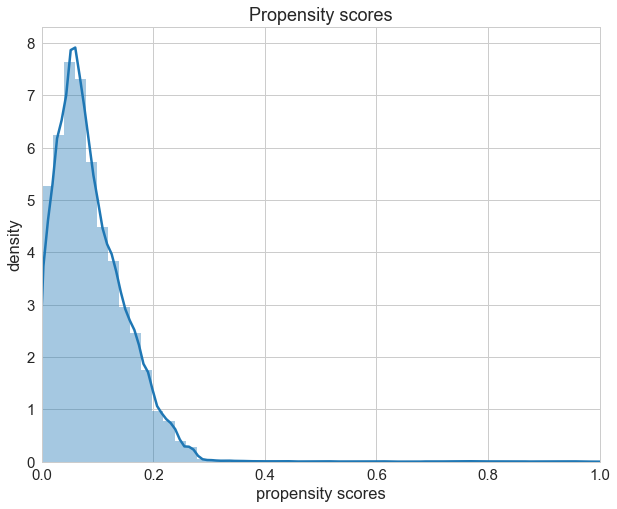

In [32]:
ax = sns.distplot(propensity[1].values)
ax.set_xlim(0, 1)
ax.set_title("Propensity scores")
ax.set_xlabel("propensity scores")
ax.set_ylabel('density');

In [33]:
X_clean['iptw'] = 1. / propensity.lookup(np.arange(propensity.shape[0]), X_clean['Lei'])

In [34]:
X_clean.describe()

,logExpend_nt,frota_flex,Pr_int_gas,Pr_int_etl,Lei,pop,homens,trend_id,educ1a3,educ4a7,educmais8,ES,MS,MG,PR,MT,BA,SE,PE,iptw
count,60557.000000,6.055700e+04,60557.000000,60557.000000,60557.000000,6.055700e+04,60557.000000,60557.000000,60557.000000,60557.000000,60557.000000,60557.000000,60557.000000,60557.000000,60557.000000,60557.000000,60557.000000,60557.000000,60557.000000,60557.000000
mean,7.569502,1.021437e+04,1.251253,0.847252,0.078967,2.517196e+05,0.490298,21033.410156,0.228305,0.195533,0.508514,0.031309,0.014697,0.127434,0.054940,0.014664,0.067342,0.008422,0.050746,1.800341
std,1.169158,5.003665e+04,0.097662,0.187088,0.269831,6.661781e+05,0.010957,16003.053711,0.086664,0.068083,0.106663,0.174144,0.120411,0.333336,0.227777,0.120279,0.250804,0.091371,0.219611,5.129199
min,0.736228,0.000000e+00,0.939376,0.014727,0.000000,1.544500e+04,0.242037,20.000000,0.076200,0.044900,0.114830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.826616,1.522500e+02,1.178728,0.736147,0.000000,7.564400e+04,0.484279,8020.000000,0.167300,0.140790,0.442290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.045785
50%,7.473807,1.852917e+03,1.248017,0.863160,0.000000,1.105130e+05,0.490096,17238.000000,0.204110,0.191640,0.518400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.083916
75%,8.237213,7.319918e+03,1.321536,0.971109,0.000000,2.196980e+05,0.496656,31122.000000,0.264360,0.245600,0.584360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.154219
max,12.840391,1.942614e+06,1.630431,1.543319,1.000000,1.137668e+07,0.543312,72540.000000,0.615900,0.460920,0.807040,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,482.944013


In [35]:
glm = sm.GLM(database['S_int_gas'], database[covariates], 
             freq_weights=X_clean['iptw'])
res = glm.fit()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              S_int_gas   No. Observations:                60557
Model:                            GLM   Df Residuals:                   109004
Model Family:                Gaussian   Df Model:                           18
Link Function:               identity   Scale:                0.00466213058319
Method:                          IRLS   Log-Likelihood:             1.5490e+05
Date:                Mon, 07 May 2018   Deviance:                       508.19
Time:                        23:19:26   Pearson chi2:                     508.
No. Iterations:                     2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
logExpend_nt    -0.0050      0.000    -13.939      0.000      -0.006      -0.004
frota_flex   -2.522e-08   3.91e-09     -6.442      0.000   -3.29e-08   -1.75e-08
Pr_int_gas      -0.3659      0.004    -82.954      0.000      -0.375      -0.357
Pr_int_etl       0.4011      0.002    208.759      0.000       0.397       0.405
Lei              0.0338      0.001     42.981      0.000       0.032       0.035
pop           1.094e-08   5.94e-10     18.421      0.000    9.78e-09    1.21e-08
homens           1.2749      0.016     80.297      0.000       1.244       1.306
trend_id     -2.642e-06   2.51e-08   -105.293      0.000   -2.69e-06   -2.59e-06
educ1a3          0.3696      0.011     34.585      0.000       0.349       0.391
educ4a7          0.6889      0.010     71.358      0.000       0.670       0.708
educmais8        0.4479      0.010     45.954      0.000       0.429       0.467
ES              -0.0624      0.001    -58.455      0.000      -0.064      -0.060
MS              -0.0611      0.001    -45.853      0.000      -0.064      -0.058
MG              -0.0309      0.001    -39.069      0.000      -0.032      -0.029
PR              -0.0412      0.001    -45.200      0.000      -0.043      -0.039
MT              -0.1121      0.002    -61.934      0.000      -0.116      -0.109
BA              -0.0308      0.001    -30.284      0.000      -0.033      -0.029
SE               0.1065      0.002     53.266      0.000       0.103       0.110
PE               0.0195      0.001     16.583      0.000       0.017       0.022
================================================================================
"""

In [36]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              S_int_gas   No. Observations:                60557
Model:                            GLM   Df Residuals:                   109004
Model Family:                Gaussian   Df Model:                           18
Link Function:               identity   Scale:                0.00466213058319
Method:                          IRLS   Log-Likelihood:             1.5490e+05
Date:                Mon, 07 May 2018   Deviance:                       508.19
Time:                        23:19:54   Pearson chi2:                     508.
No. Iterations:                     2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
logExpend_nt    -0.0050      0.000    -13.939      0.000      -0.006      -0.004
frota_flex   -2.522e-08   3.91e-09     -6.442      0.000   -3.29e-08   -1.75e-08
Pr_int_gas      -0.3659      0.004    -82.954      0.000      -0.375      -0.357
Pr_int_etl       0.4011      0.002    208.759      0.000       0.397       0.405
Lei              0.0338      0.001     42.981      0.000       0.032       0.035
pop           1.094e-08   5.94e-10     18.421      0.000    9.78e-09    1.21e-08
homens           1.2749      0.016     80.297      0.000       1.244       1.306
trend_id     -2.642e-06   2.51e-08   -105.293      0.000   -2.69e-06   -2.59e-06
educ1a3          0.3696      0.011     34.585      0.000       0.349       0.391
educ4a7          0.6889      0.010     71.358      0.000       0.670       0.708
educmais8        0.4479      0.010     45.954      0.000       0.429       0.467
ES              -0.0624      0.001    -58.455      0.000      -0.064      -0.060
MS              -0.0611      0.001    -45.853      0.000      -0.064      -0.058
MG              -0.0309      0.001    -39.069      0.000      -0.032      -0.029
PR              -0.0412      0.001    -45.200      0.000      -0.043      -0.039
MT              -0.1121      0.002    -61.934      0.000      -0.116      -0.109
BA              -0.0308      0.001    -30.284      0.000      -0.033      -0.029
SE               0.1065      0.002     53.266      0.000       0.103       0.110
PE               0.0195      0.001     16.583      0.000       0.017       0.022
================================================================================
"""

In [37]:
glm2 = sm.GLM(database['S_int_gas'], database[covariates]) 
#             family=sm.families.Poisson(),
#             freq_weights=X_clean['iptw'])
res2 = glm2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              S_int_gas   No. Observations:                60557
Model:                            GLM   Df Residuals:                    60538
Model Family:                Gaussian   Df Model:                           18
Link Function:               identity   Scale:                0.00598860496111
Method:                          IRLS   Log-Likelihood:                 69045.
Date:                Mon, 07 May 2018   Deviance:                       362.54
Time:                        23:21:12   Pearson chi2:                     363.
No. Iterations:                     2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
logExpend_nt    -0.0014      0.001     -2.695      0.007      -0.002      -0.000
frota_flex   -1.254e-07   8.77e-09    -14.302      0.000   -1.43e-07   -1.08e-07
Pr_int_gas      -0.3624      0.006    -61.578      0.000      -0.374      -0.351
Pr_int_etl       0.3937      0.002    159.641      0.000       0.389       0.399
Lei              0.0460      0.001     31.309      0.000       0.043       0.049
pop           1.314e-08   7.44e-10     17.678      0.000    1.17e-08    1.46e-08
homens           1.0811      0.022     48.480      0.000       1.037       1.125
trend_id     -2.823e-06   3.31e-08    -85.383      0.000   -2.89e-06   -2.76e-06
educ1a3          0.4327      0.015     29.427      0.000       0.404       0.462
educ4a7          0.8086      0.013     61.998      0.000       0.783       0.834
educmais8        0.5218      0.014     36.866      0.000       0.494       0.550
ES              -0.0357      0.002    -17.599      0.000      -0.040      -0.032
MS              -0.0619      0.003    -23.010      0.000      -0.067      -0.057
MG              -0.0443      0.001    -38.984      0.000      -0.047      -0.042
PR              -0.0374      0.001    -25.845      0.000      -0.040      -0.035
MT              -0.0792      0.003    -28.954      0.000      -0.085      -0.074
BA              -0.0347      0.001    -24.088      0.000      -0.037      -0.032
SE               0.0761      0.004     21.274      0.000       0.069       0.083
PE               0.0150      0.002      9.975      0.000       0.012       0.018
================================================================================
"""

In [152]:
info2 = ['S_int_gas', 'logExpend_nt', 'frota_flex', 'Lei', 'pop', 'homens', \
           'trend_id', 'educ1a3', 'educ4a7', 'educmais8', 'ES', 'MS', 'MG', 'PR', 'MT', 'BA', 'SE', 'PE', \
           'Pr_int_gas', 'Pr_int_etl', 'oil', 'white_sugar']
data2 = data[info2].dropna()

In [153]:
from linearmodels.iv import IVGMM
formula = 'S_int_gas ~ logExpend_nt + frota_flex + Lei + pop + homens + \
           trend_id + educ1a3 + educ4a7 + educmais8 + ES + MS + MG + PR + MT + BA + SE + PE \
           [Pr_int_gas + Pr_int_etl ~ oil + white_sugar]'
mod = IVGMM.from_formula(formula, data2, weights=X_clean['iptw'])

In [154]:
data['white_sugar'].isnull().sum().sum()
res3 = mod.fit()
#IVGMMResults
res3.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              S_int_gas   R-squared:                      0.9941
Estimator:                     IV-GMM   Adj. R-squared:                 0.9941
No. Observations:               60557   F-statistic:                  9.48e+06
Date:                Sun, May 06 2018   P-value (F-stat)                0.0000
Time:                        22:44:33   Distribution:                 chi2(19)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
================================================================================
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
logExpend_nt     0.0007     0.0009     0.7409     0.4587     -0.0011      0.0025
frota_flex   -9.475e-08  1.217e-08    -7.7869     0.0000  -1.186e-07   -7.09e-08
Lei              0.0344     0.0018     19.320     0.0000      0.0309      0.0379
pop           1.117e-08  8.974e-10     12.449     0.0000   9.413e-09   1.293e-08
homens           1.1104     0.0487     22.804     0.0000      1.0150      1.2058
trend_id     -2.647e-06  7.845e-08    -33.746     0.0000  -2.801e-06  -2.493e-06
educ1a3          0.4347     0.0304     14.289     0.0000      0.3751      0.4944
educ4a7          0.7330     0.0318     23.073     0.0000      0.6708      0.7953
educmais8        0.4859     0.0312     15.580     0.0000      0.4248      0.5470
ES              -0.0550     0.0018    -30.933     0.0000     -0.0585     -0.0515
MS              -0.0607     0.0032    -19.197     0.0000     -0.0669     -0.0545
MG              -0.0273     0.0011    -24.192     0.0000     -0.0295     -0.0251
PR              -0.0425     0.0018    -23.405     0.0000     -0.0461     -0.0390
MT              -0.1237     0.0050    -24.559     0.0000     -0.1335     -0.1138
BA              -0.0351     0.0021    -16.358     0.0000     -0.0393     -0.0309
SE               0.0923     0.0034     26.986     0.0000      0.0856      0.0990
PE               0.0158     0.0015     10.570     0.0000      0.0129      0.0188
Pr_int_gas      -0.4072     0.0279    -14.610     0.0000     -0.4618     -0.3525
Pr_int_etl       0.4585     0.0079     58.035     0.0000      0.4430      0.4740
================================================================================

Endogenous: Pr_int_gas, Pr_int_etl
Instruments: oil, white_sugar
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
"""

In [164]:
# Testing the random forests:
reg = RandomForestRegressor(random_state=42)
reg.fit(database[covariates], database['S_int_gas'], sample_weight=X_clean['iptw'].values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)